In [5]:
# Standard libraries
from datetime import datetime as dt
from concurrent.futures import ThreadPoolExecutor

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Statistical analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Machine learning – scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Machine learning – XGBoost
from xgboost import XGBClassifier
import xgboost as xgb

# Machine learning – CatBoost
from catboost import CatBoostClassifier

# Class balancing
from imblearn.over_sampling import SMOTE


import shap


In [22]:
def read_data():
    df_credits = pd.read_csv('../data/User Credits Student Access.csv', encoding='utf-8')
    df_atlas = pd.read_csv('../data/Atlas Cechu Student Access.csv', encoding='utf-8')
    df_payments = pd.read_csv('../data/Payments Student Access.csv', encoding='utf-8')
    return df_credits, df_atlas, df_payments

def data_cleaning(df_credits, df_payments):
    df_c_negative = df_credits[df_credits['credits']<0]
    df_credits[df_credits.user.isin(df_c_negative.user) == True]

    # IDK what I'm doing with payments
    df_payments[df_payments.user.isin(df_c_negative.user)==True].sort_values(['user','created_at'])
    df_payments.state.unique()
    df_payments[df_payments.user=='STUD54678']
    df_credits[df_credits.user=='STUD54678']

    df_credits_cleaned = df_credits[df_credits['credits']>0]
    df_payments_cleaned = df_payments[df_payments['user'].notna()] # we threw out from payments 2345 observations

    return df_credits_cleaned, df_payments_cleaned

def get_merged_table():
    df_credits, df_atlas, df_payments = read_data()
    _, df_payments_cleaned = data_cleaning(df_credits, df_payments)
    df_merge_full = pd.merge(df_payments_cleaned, df_atlas, how='inner', left_on='user', right_on='user_id')
    df_merge_full.rename(columns={'credits_x':'credits_payments', 'credits_y':'credits_credits'})
    df_merge_full = pd.get_dummies(df_merge_full, columns=['type'], drop_first=True)
    df_merge_full = df_merge_full.astype({col: int for col in df_merge_full.select_dtypes(include='bool').columns})

    df_merge_full['created_at'] = pd.to_datetime(df_merge_full['created_at'])

    df_merge_full['day'] = df_merge_full['created_at'].dt.day
    df_merge_full['month'] = df_merge_full['created_at'].dt.month
    df_merge_full['year'] = df_merge_full['created_at'].dt.year
    df_merge_full['weekday'] = df_merge_full['created_at'].dt.weekday

    print(df_merge_full[df_merge_full.year.isin([2025])].shape[0])
    print(df_merge_full[df_merge_full.year.isin([2017])].shape[0])

    df_merge_full = df_merge_full[(df_merge_full['year'] != 2017) & (df_merge_full['year'] != 2025)]
    df_merge_full = df_merge_full.drop(columns=['year'])
    df_merge_full = df_merge_full.drop(columns=['created_at'])
    return df_merge_full

# split dataset into three categories
def get_split_values(df_merge_full, value:int):
    col_name = f'credits_{value}+'
    df_modeling = df_merge_full.drop(columns=['id', 'changed_at', 'user', 'batch', 'state', 'user_id'])
    df_modeling[col_name] = (df_modeling['credits'] > value).astype(int)
    df_modeling = df_modeling.drop(columns=['credits'])

    fig = px.bar(pd.DataFrame(df_modeling[col_name].value_counts().reset_index()), x=col_name, y='count', title='Credits Category Distribution')
    fig.show()
    
    df_modeling = df_modeling[df_modeling[col_name].isnull()==False] # clean data from null values
    return df_modeling, col_name

def split_data(X, y, test_size=0.2, stratify=True, random_state=42):
    """
    Split data into training and testing sets with optional stratification.

    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target variable.
        test_size (float): Proportion of data to use as test set.
        stratify (bool): Whether to stratify split based on y.
        random_state (int): Seed for reproducibility.

    Returns:
        Tuple: (X_train, X_test, y_train, y_test)
    """
    return train_test_split(
        X,
        y,
        test_size=test_size,
        stratify=y if stratify else None,
        random_state=random_state
    )

def get_smote_train(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    return X_train_smote, y_train_smote

def compute_vif_column(X_values, i, col_name):
    print(f"Computing VIF for column: {col_name}")
    return variance_inflation_factor(X_values, i)

def remove_high_vif_parallel(X, thresh=10.0, verbose=True, n_iterations=10, max_workers=4):
    """
    Removes columns with high VIF using multithreading to speed up VIF computation.
    """
    X = X.copy()
    X_numeric = X.select_dtypes(include='number')
    dropped = []
    iterations = 0

    while iterations < n_iterations:
        print(f'This is in iteration number: {iterations}')
        X_values = X_numeric.values
        columns = list(X.columns)
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            vifs = list(executor.map(
                lambda pair: compute_vif_column(X_values, pair[0], pair[1]),
                enumerate(columns)
            ))

        vif_series = pd.Series(vifs, index=columns)
        max_vif = vif_series.max()

        if max_vif > thresh:
            drop_col = vif_series.idxmax()
            if verbose:
                print(f"Dropping '{drop_col}' with VIF={max_vif:.2f}")
            X = X.drop(columns=[drop_col])
            dropped.append(drop_col)
        else:
            break

        iterations += 1

    return X, dropped

In [23]:
df_merge_full = get_merged_table()
df_modeling, colname = get_split_values(df_merge_full, 550)

y = df_modeling[colname]
X = df_modeling.drop(columns=[colname])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , train_size=0.8, random_state=42)

X_train_smote, y_train_smote = get_smote_train(X_train, y_train)

/var/folders/_c/8b17td616wg63_3tyjv1dhb80000gn/T/ipykernel_7722/1558344650.py:32: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/_c/8b17td616wg63_3tyjv1dhb80000gn/T/ipykernel_7722/1558344650.py:33: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/_c/8b17td616wg63_3tyjv1dhb80000gn/T/ipykernel_7722/1558344650.py:34: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

3956
34


/var/folders/_c/8b17td616wg63_3tyjv1dhb80000gn/T/ipykernel_7722/1558344650.py:49: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning:

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.



In [8]:
_, _, df_payments = read_data()
df_payments[(df_payments['user'].isna())&(df_payments['credits']>=500)]
df_payments[(df_payments['user'].isna())&(df_payments['credits']<500)]
df_payments[(df_payments['user'].isna())&(df_payments['credits'].isna())]

df_payments[df_payments['id'].isnull()]

,id,created_at,changed_at,user,batch,credits,state,type
1424,NaN,Anna,Prchalová,NaN,1299589028/3030,NaN,NaN,NaN


# Modeling

# Grid Search

In [9]:
# catboost clf
grid_cat = {
    'depth':[5,10,15]
}

model_cat = CatBoostClassifier(
    iterations=800,
    eval_metric='Accuracy',
    verbose=200, # control how often the model will print out output - e.g. when verbose is set to 50 = every 50 iteretion print out current status,
    loss_function='CrossEntropy',
    learning_rate=0.1
)

grid_cat = GridSearchCV(model_cat, grid_cat, cv=3, scoring='accuracy')
grid_cat.fit(X_train_smote, y_train_smote, eval_set=(X_test, y_test), early_stopping_rounds=50)

0:	learn: 0.6877181	test: 0.6391437	best: 0.6391437 (0)	total: 68ms	remaining: 54.4s
200:	learn: 0.9128867	test: 0.7199651	best: 0.7201835 (191)	total: 2.1s	remaining: 6.25s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7304499782
bestIteration = 342

Shrink model to first 343 iterations.
0:	learn: 0.6156664	test: 0.5412844	best: 0.5412844 (0)	total: 8.73ms	remaining: 6.98s
200:	learn: 0.8358921	test: 0.7354740	best: 0.7356924 (199)	total: 1.76s	remaining: 5.24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7400611621
bestIteration = 287

Shrink model to first 288 iterations.
0:	learn: 0.6125262	test: 0.6079074	best: 0.6079074 (0)	total: 9.17ms	remaining: 7.33s
200:	learn: 0.8183880	test: 0.7256444	best: 0.7265181 (197)	total: 1.76s	remaining: 5.25s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7350371341
bestIteration = 259

Shrink model to first 260 iterations.
0:	learn: 0.7365666	test: 0.6260376	best: 0.6260376 (0)	to

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x176a7ca00>,
             param_grid={'depth': [5, 10, 15]}, scoring='accuracy')

In [69]:
grid_cat.best_params_

{'depth': 12, 'learning_rate': 0.1}

In [10]:
# XGBClassifier

xgb.set_config(verbosity=1)

param_grid = {
    'n_estimators': np.array(range(100, 2000, 100)),
    'max_depth': np.array(range(1, 20, 1)),
    'learning_rate': np.array(range(5, 25, 5))/100,
    'eval_metric': ['logloss', 'error', 'auc'],
}

model = XGBClassifier(objective='binary:logistic', use_label_encoder=False)

grid_XGB = RandomizedSearchCV(model, param_grid, cv=3, scoring='accuracy', n_iter=20, n_jobs=-1)
grid_XGB.fit(X_train_smote, y_train_smote, eval_set=[(X_test, y_test)], verbose=200)

/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:43:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:43:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.35802
[0]	validation_0-error:0.37571


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:43:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.39406


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:43:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.63513


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:43:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.64798


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:43:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.65393


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:43:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.66235


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:43:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:43:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.66532
[0]	validation_0-logloss:0.66880


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:43:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.66227
[200]	validation_0-error:0.26693
[200]	validation_0-error:0.25885
[200]	validation_0-error:0.27152
[200]	validation_0-auc:0.71641
[200]	validation_0-auc:0.75067
[200]	validation_0-auc:0.74511
[200]	validation_0-logloss:0.90753
[200]	validation_0-logloss:0.90272
[200]	validation_0-logloss:0.72059
[200]	validation_0-logloss:0.72004
[400]	validation_0-error:0.26999
[400]	validation_0-error:0.26365
[400]	validation_0-error:0.27632
[400]	validation_0-auc:0.71403
[400]	validation_0-auc:0.74537
[400]	validation_0-auc:0.74215
[400]	validation_0-logloss:1.02687
[400]	validation_0-logloss:1.02001
[600]	validation_0-error:0.26977
[400]	validation_0-logloss:0.79329
[400]	validation_0-logloss:0.79611
[600]	validation_0-error:0.26453
[600]	validation_0-error:0.27720
[600]	validation_0-auc:0.71277
[600]	validation_0-auc:0.74412
[600]	validation_0-auc:0.74064
[600]	validation_0-logloss:1.09198
[600]	validation_0-logloss:1.08586
[800]	validation_0-error:0.26911
[600]	va

/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:44:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	validation_0-auc:0.73885
[0]	validation_0-logloss:0.66541
[899]	validation_0-logloss:0.87980
[899]	validation_0-logloss:0.88809
[1000]	validation_0-logloss:1.16453
[1200]	validation_0-error:0.26999


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:44:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.66891
[1200]	validation_0-error:0.26322
[1200]	validation_0-auc:0.71066
[1200]	validation_0-error:0.28419


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:44:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.68092
[1200]	validation_0-auc:0.74292
[1200]	validation_0-auc:0.73813
[1200]	validation_0-logloss:1.19400
[1400]	validation_0-error:0.26955
[200]	validation_0-logloss:0.70814
[200]	validation_0-logloss:0.59208
[1400]	validation_0-error:0.26322
[1400]	validation_0-auc:0.71037
[1400]	validation_0-error:0.28419
[1400]	validation_0-auc:0.74234
[1400]	validation_0-auc:0.73765
[200]	validation_0-logloss:0.72168
[400]	validation_0-logloss:0.60509
[1400]	validation_0-logloss:1.21800
[1600]	validation_0-error:0.26955
[1600]	validation_0-error:0.26453
[1599]	validation_0-auc:0.70954
[400]	validation_0-logloss:0.78264
[1600]	validation_0-error:0.28440
[1599]	validation_0-auc:0.74222


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:45:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.68724
[600]	validation_0-logloss:0.62645
[1599]	validation_0-auc:0.73752


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:45:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.68848
[1600]	validation_0-logloss:1.23819
[400]	validation_0-logloss:0.79702
[1800]	validation_0-error:0.26999


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:45:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.66644
[1800]	validation_0-error:0.26562
[200]	validation_0-logloss:0.56029
[600]	validation_0-logloss:0.82580
[1800]	validation_0-error:0.28309
[1699]	validation_0-logloss:1.24652
[800]	validation_0-logloss:0.64976
[1899]	validation_0-error:0.26977
[200]	validation_0-logloss:0.57225


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:45:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.69980
[1899]	validation_0-error:0.26496
[1899]	validation_0-error:0.28375


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:45:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.69194
[600]	validation_0-logloss:0.84398


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:45:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.66559
[400]	validation_0-logloss:0.54934
[1000]	validation_0-logloss:0.67292


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:45:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[200]	validation_0-auc:0.72411
[0]	validation_0-auc:0.70216
[400]	validation_0-logloss:0.55777
[800]	validation_0-logloss:0.85770
[1200]	validation_0-logloss:0.69595
[600]	validation_0-logloss:0.54526
[800]	validation_0-logloss:0.87768
[200]	validation_0-auc:0.73978
[600]	validation_0-logloss:0.55303
[400]	validation_0-auc:0.72123
[200]	validation_0-auc:0.73496
[200]	validation_0-auc:0.72637
[1000]	validation_0-logloss:0.88151
[1400]	validation_0-logloss:0.72016
[800]	validation_0-logloss:0.54579
[1000]	validation_0-logloss:0.90484
[200]	validation_0-auc:0.74298
[800]	validation_0-logloss:0.55187
[400]	validation_0-auc:0.73922
[600]	validation_0-auc:0.71852
[400]	validation_0-auc:0.73490
[1600]	validation_0-logloss:0.74154
[1000]	validation_0-logloss:0.54933
[1200]	validation_0-logloss:0.90233
[1000]	validation_0-logloss:0.55497
[1200]	validation_0-logloss:0.92600
[400]	validation_0-auc:0.72414
[400]	validation_0-auc:0.74203
[800]	validation_0-auc:0.71728
[1799]	validation_0-logloss:0.

/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:46:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.69225
[1400]	validation_0-logloss:0.94411
[1400]	validation_0-logloss:0.91939
[899]	validation_0-auc:0.71723
[600]	validation_0-auc:0.72235


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:46:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.29227
[1400]	validation_0-logloss:0.56013
[1400]	validation_0-logloss:0.56328
[800]	validation_0-auc:0.73817
[600]	validation_0-auc:0.74232
[800]	validation_0-auc:0.73475
[1600]	validation_0-logloss:0.95942
[1600]	validation_0-logloss:0.93484
[899]	validation_0-auc:0.73781
[1600]	validation_0-logloss:0.56614
[899]	validation_0-auc:0.73464
[800]	validation_0-auc:0.72118
[1600]	validation_0-logloss:0.56840


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:46:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.29183
[1699]	validation_0-logloss:0.96631
[1699]	validation_0-logloss:0.94195
[200]	validation_0-auc:0.74504


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:47:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.31127
[800]	validation_0-auc:0.74187
[200]	validation_0-error:0.26409


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:47:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.33246
[1799]	validation_0-logloss:0.57248


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:47:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.36938
[1799]	validation_0-logloss:0.57553


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:47:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.37418


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:47:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.29205
[1000]	validation_0-auc:0.72026
[1000]	validation_0-auc:0.74165
[200]	validation_0-error:0.26540
[200]	validation_0-error:0.27173
[400]	validation_0-auc:0.74330
[99]	validation_0-error:0.26474
[400]	validation_0-error:0.26737
[200]	validation_0-error:0.26933


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



[200]	validation_0-error:0.27763
[200]	validation_0-error:0.28069


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:47:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.29270
[1200]	validation_0-auc:0.71936
[1200]	validation_0-auc:0.74147
[400]	validation_0-error:0.26453
[400]	validation_0-error:0.27173
[1299]	validation_0-auc:0.71885
[400]	validation_0-error:0.28266
[600]	validation_0-error:0.26715
[600]	validation_0-auc:0.74281
[99]	validation_0-error:0.26999
[1299]	validation_0-auc:0.74125
[400]	validation_0-error:0.26758


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:47:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.31455


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:47:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.52508


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:47:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.54293
[400]	validation_0-error:0.28178
[600]	validation_0-error:0.26496
[600]	validation_0-error:0.27108
[99]	validation_0-error:0.28156
[600]	validation_0-error:0.27851
[200]	validation_0-auc:0.61604
[800]	validation_0-error:0.26649
[800]	validation_0-auc:0.74237


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:48:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.52475
[200]	validation_0-auc:0.62343
[600]	validation_0-error:0.26715
[299]	validation_0-auc:0.61760
[299]	validation_0-auc:0.62976
[0]	validation_0-logloss:0.68330


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:48:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[800]	validation_0-error:0.26453
[200]	validation_0-auc:0.63080
[800]	validation_0-error:0.27108
[600]	validation_0-error:0.27741


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:48:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.68727
[800]	validation_0-error:0.27785
[299]	validation_0-auc:0.63554
[1000]	validation_0-error:0.26715
[1000]	validation_0-auc:0.74192
[200]	validation_0-logloss:0.60100
[800]	validation_0-error:0.26780


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:48:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.68873
[200]	validation_0-logloss:0.57954
[1099]	validation_0-error:0.26671
[1000]	validation_0-error:0.26496
[1000]	validation_0-error:0.27108
[800]	validation_0-error:0.27851


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:48:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.31324
[400]	validation_0-logloss:0.60423
[1000]	validation_0-error:0.27894
[200]	validation_0-logloss:0.59378
[1200]	validation_0-auc:0.74163
[400]	validation_0-logloss:0.56777
[1000]	validation_0-error:0.26693
[1199]	validation_0-error:0.26453
[1199]	validation_0-error:0.27108
[1299]	validation_0-auc:0.74142
[599]	validation_0-logloss:0.60899
[400]	validation_0-logloss:0.57712


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:48:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.32263
[1099]	validation_0-error:0.26693
[1000]	validation_0-error:0.27785
[599]	validation_0-logloss:0.56026
[1199]	validation_0-error:0.27698
[200]	validation_0-error:0.26824
[0]	validation_0-error:0.35321


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:48:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:48:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.65185


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:48:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.67645


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:48:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.67002


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:48:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.30494


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:48:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.30428
[1099]	validation_0-error:0.27676
[599]	validation_0-logloss:0.56916


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:48:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.32962


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:49:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.31324
[400]	validation_0-error:0.26824
[200]	validation_0-error:0.26606
[200]	validation_0-error:0.27851
[200]	validation_0-auc:0.72059
[200]	validation_0-auc:0.74551
[200]	validation_0-auc:0.74519
[200]	validation_0-error:0.26715
[600]	validation_0-error:0.26889
[200]	validation_0-error:0.26584
[200]	validation_0-error:0.26824
[299]	validation_0-error:0.26889
[400]	validation_0-error:0.26496
[200]	validation_0-error:0.27283


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:49:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.32263
[400]	validation_0-auc:0.71965
[400]	validation_0-error:0.27872
[400]	validation_0-auc:0.74295
[299]	validation_0-error:0.26562
[400]	validation_0-auc:0.74147


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:49:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.35321
[800]	validation_0-error:0.26758
[299]	validation_0-error:0.27261
[400]	validation_0-error:0.26824


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:49:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.29270
[600]	validation_0-error:0.26540
[600]	validation_0-auc:0.71845
[600]	validation_0-error:0.27632
[600]	validation_0-auc:0.74223
[200]	validation_0-error:0.26606
[600]	validation_0-auc:0.74119
[1000]	validation_0-error:0.26780
[200]	validation_0-error:0.27851
[600]	validation_0-error:0.26889
[200]	validation_0-error:0.26977
[800]	validation_0-auc:0.71718
[800]	validation_0-error:0.27763
[800]	validation_0-auc:0.74204
[1099]	validation_0-error:0.26737
[800]	validation_0-error:0.26496
[899]	validation_0-auc:0.71602


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:50:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[400]	validation_0-error:0.26496
[0]	validation_0-error:0.29118
[899]	validation_0-auc:0.74125
[800]	validation_0-auc:0.74048


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:50:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.31389
[400]	validation_0-error:0.26955
[800]	validation_0-error:0.26758


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:50:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.66608
[1000]	validation_0-error:0.27894
[400]	validation_0-error:0.27872
[899]	validation_0-auc:0.74062
[1000]	validation_0-error:0.26409
[600]	validation_0-error:0.26540
[1099]	validation_0-error:0.27785


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:50:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.69997
[200]	validation_0-error:0.27086
[1000]	validation_0-error:0.26780
[600]	validation_0-error:0.26846
[1099]	validation_0-error:0.26453


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:50:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.69065


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:50:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.42049
[600]	validation_0-error:0.27632
[200]	validation_0-error:0.27982
[200]	validation_0-auc:0.71137
[800]	validation_0-error:0.26496
[200]	validation_0-error:0.29817
[200]	validation_0-auc:0.73964
[1200]	validation_0-error:0.26758
[800]	validation_0-error:0.26868
[400]	validation_0-error:0.26911
[200]	validation_0-auc:0.73575
[299]	validation_0-error:0.29161
[800]	validation_0-error:0.27763
[400]	validation_0-auc:0.71164
[400]	validation_0-error:0.27916
[1000]	validation_0-error:0.26409


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:50:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.44495
[400]	validation_0-auc:0.74013
[1400]	validation_0-error:0.26737
[1000]	validation_0-error:0.26802
[600]	validation_0-error:0.26671
[400]	validation_0-auc:0.73536
[200]	validation_0-error:0.30079
[600]	validation_0-auc:0.71122
[1000]	validation_0-error:0.27894
[1200]	validation_0-error:0.26387
[600]	validation_0-error:0.28113
[600]	validation_0-auc:0.73956
[299]	validation_0-error:0.29817
[1600]	validation_0-error:0.26671
[1200]	validation_0-error:0.26933


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:51:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-error:0.48362
[800]	validation_0-error:0.26933
[600]	validation_0-auc:0.73470
[1400]	validation_0-error:0.26453
[800]	validation_0-auc:0.70985
[800]	validation_0-auc:0.73966
[1200]	validation_0-error:0.27851
[1399]	validation_0-error:0.26868
[800]	validation_0-error:0.28025
[200]	validation_0-error:0.32787
[1800]	validation_0-error:0.26606


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:51:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.67801
[299]	validation_0-error:0.31761
[1000]	validation_0-error:0.26868
[1600]	validation_0-error:0.26431
[1899]	validation_0-error:0.26606
[800]	validation_0-auc:0.73433
[1000]	validation_0-auc:0.73947


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:51:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.68526
[1000]	validation_0-auc:0.71000
[1400]	validation_0-error:0.27741


/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.68693
[1000]	validation_0-error:0.28091
[200]	validation_0-logloss:0.60049
[1200]	validation_0-error:0.26933
[299]	validation_0-logloss:0.62138
[1200]	validation_0-auc:0.73986
[200]	validation_0-logloss:0.54149
[1800]	validation_0-error:0.26343
[1000]	validation_0-auc:0.73396
[1200]	validation_0-auc:0.70929
[200]	validation_0-logloss:0.55178
[299]	validation_0-logloss:0.53962
[1600]	validation_0-error:0.27872
[1899]	validation_0-error:0.26409
[1200]	validation_0-error:0.28222
[299]	validation_0-logloss:0.54823
[1400]	validation_0-auc:0.73979
[1399]	validation_0-error:0.26780
[1400]	validation_0-auc:0.70885
[1200]	validation_0-auc:0.73342
[1800]	validation_0-error:0.27851
[1399]	validation_0-error:0.28244
[1600]	validation_0-auc:0.73981
[1899]	validation_0-error:0.27851
[1600]	validation_0-auc:0.70840
[1400]	validation_0-auc:0.73324
[1699]	validation_0-auc:0.73950
[1699]	validation_0-auc:0.70838
[1600]	validation_0-auc:0.73306
[1699]	validation_0-auc:0.73318
[

/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[21:52:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




[200]	validation_0-error:0.25644
[299]	validation_0-error:0.25775


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'eval_metric': ['logloss', 'error',
                                                        'auc'],
                                        'learning_rate': array([0.05, 0.1 , 0.15, 0.2 ]),
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900])},
                   scoring='accuracy')

In [11]:
##### logistic regression model
model_logit = LogisticRegression()
model_logit.fit(X_train_smote, y_train_smote)

##### Decision Tree
param_grid = {
    'max_depth': np.array(range(4, 15, 2)),
    'criterion': ['gini', 'entropy']
}

model_dt = DecisionTreeClassifier(random_state=42)

grid_dt = RandomizedSearchCV(model_dt, param_grid, cv=None, scoring='accuracy', n_iter=10, n_jobs=-1)
grid_dt.fit(X_train_smote, y_train_smote)

##### Random Forest
param_grid = {
    'n_estimators': np.array(range(100, 1000, 300)),
    'max_depth': np.array(range(5, 15, 3)),
    'criterion': ['gini', 'entropy']
}

model_rf = RandomForestClassifier(random_state=42)

grid_rf = RandomizedSearchCV(model_rf, param_grid, cv=None, scoring='accuracy', n_iter=20, n_jobs=-1)
grid_rf.fit(X_train_smote, y_train_smote)

/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 5,  8, 11, 14]),
                                        'n_estimators': array([100, 400, 700])},
                   scoring='accuracy')

In [12]:
##### Random Forest
param_grid = {
    'n_estimators': np.array(range(100, 1000, 300)),
    'max_depth': np.array(range(5, 15, 3)),
    'criterion': ['gini', 'entropy']
}

model_rf = RandomForestClassifier(random_state=42)

grid_rf = RandomizedSearchCV(model_rf, param_grid, cv=None, scoring='accuracy', n_iter=30, n_jobs=-1)
grid_rf.fit(X_train_smote, y_train_smote)

/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 24 is smaller than n_iter=30. Running 24 iterations. For exhaustive searches, use GridSearchCV.



RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 5,  8, 11, 14]),
                                        'n_estimators': array([100, 400, 700])},
                   scoring='accuracy')

In [13]:


def evaluate_model_separate(list_model, list_model_name, X_test, y_test):
    """
    Evaluates classification models and returns:
    - DataFrame with metrics for class '0' and '1'
    - DataFrame with overall accuracy per model
    - Dictionary with confusion matrices per model

    Parameters:
    - list_model: list of trained model objects
    - list_model_name: list of corresponding model names
    - X_test: test features
    - y_test: test labels

    Returns:
    - df_class: DataFrame with metrics for class '0' and '1'
    - df_accuracy: DataFrame with overall accuracy per model
    - cm_dict: Dictionary of confusion matrices {model_name: matrix}
    """
    class_rows = []
    accuracy_rows = []
    cm_dict = {}

    for model, name in zip(list_model, list_model_name):
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        cm_dict[name] = cm  # store confusion matrix in dictionary

        for label, metrics in report.items():
            if label in ['0', '1']:
                class_rows.append({
                    'model': name,
                    'class': label,
                    'precision': metrics['precision'],
                    'recall': metrics['recall'],
                    'f1-score': metrics['f1-score'],
                    'support': metrics['support']
                })
            elif label == 'accuracy':
                accuracy_rows.append({
                    'model': name,
                    'accuracy': metrics
                })

    df_class = pd.DataFrame(class_rows)
    df_accuracy = pd.DataFrame(accuracy_rows)
    return df_class, df_accuracy, cm_dict

In [14]:
best_dt = grid_dt.best_estimator_
best_rf = grid_rf.best_estimator_
best_cat = grid_cat.best_estimator_
best_XGB = grid_XGB.best_estimator_

list_model = [model_logit, best_dt, best_rf, best_cat, best_XGB]
list_model_name = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'CatBoost', 'XGBoost']

df_class, df_accuracy, cm_dict = evaluate_model_separate(list_model, list_model_name, X_test, y_test)

In [20]:
df_class

,model,class,precision,recall,f1-score,support
0,Logistic Regression,0,0.763247,0.839690,0.799646,3225.0
1,Logistic Regression,1,0.498058,0.379157,0.430550,1353.0
2,Decision Tree,0,0.798384,0.766202,0.781962,3225.0
3,Decision Tree,1,0.491571,0.538803,0.514104,1353.0
4,Random Forest,0,0.809183,0.841550,0.825049,3225.0
5,Random Forest,1,0.582516,0.526977,0.553357,1353.0
6,CatBoost,0,0.787904,0.892713,0.837040,3225.0
7,CatBoost,1,0.625541,0.427199,0.507686,1353.0
8,XGBoost,0,0.788923,0.865736,0.825547,3225.0
9,XGBoost,1,0.583253,0.447894,0.506689,1353.0


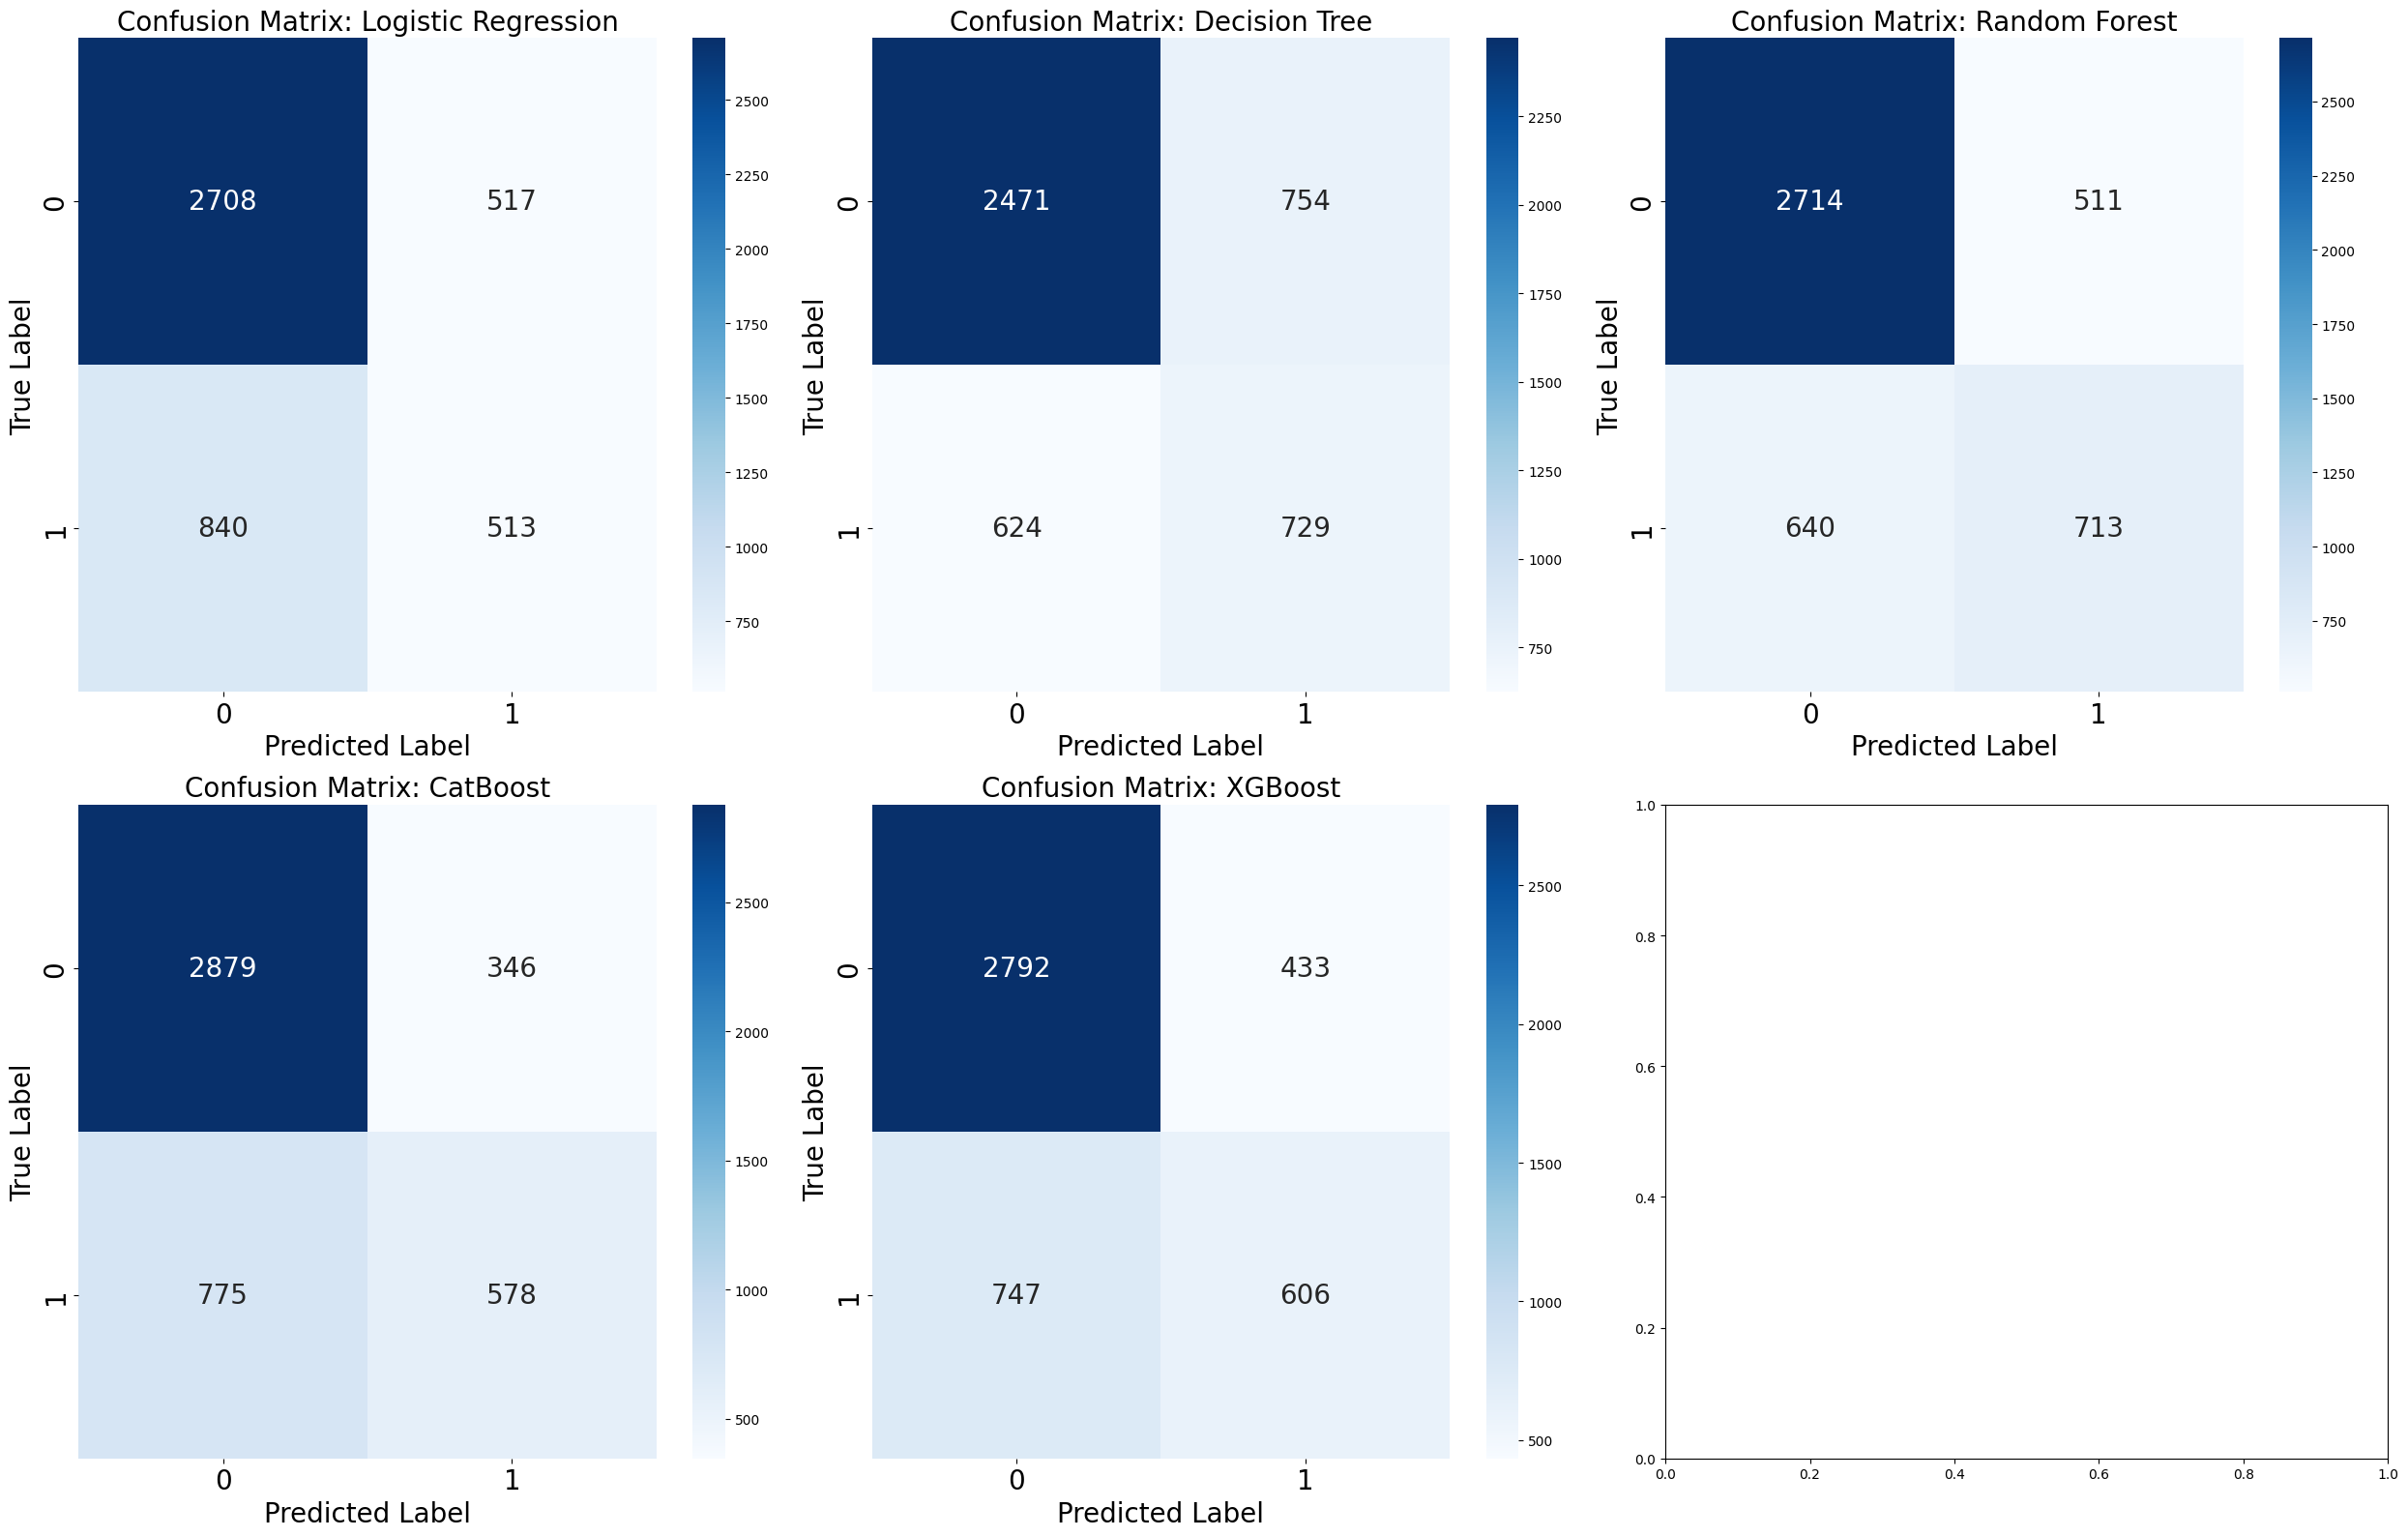

In [15]:

def plot_confusion_matrices(cm_dict, class_labels=['0', '1']):
    """
    Plots confusion matrices stored in a dictionary using Seaborn heatmaps in a dynamic layout.

    Parameters:
    - cm_dict: Dictionary of {model_name: confusion_matrix}
    - class_labels: List of class labels (default ['0', '1'])
    """
    num_models = len(cm_dict)
    rows = 2  # Set the number of rows to 2
    fig, axs = plt.subplots(rows, 3, figsize=(25, 8 * rows))  # Adjust figure size dynamically
    axs = axs.flatten()  # Flatten the 2D array of axes into a 1D array
    for i, (model_name, cm) in enumerate(cm_dict.items()):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[i],
                    xticklabels=class_labels, yticklabels=class_labels, annot_kws={'size': 20})  # Increase font size of numeric labels
        axs[i].set_xlabel('Predicted Label', fontsize=20)  # Increase font size of x-axis label
        axs[i].set_ylabel('True Label', fontsize=20)  # Increase font size of y-axis label
        axs[i].tick_params(axis='both', labelsize=20)  # Increase font size of tick labels
        axs[i].set_title(f'Confusion Matrix: {model_name}', fontsize=20)  # Increase font size of title
    plt.tight_layout()
    plt.show()

df_class, df_accuracy, cm_dict = evaluate_model_separate(list_model, list_model_name, X_test, y_test)
plot_confusion_matrices(cm_dict)

In [16]:
best_rf = grid_rf.best_estimator_

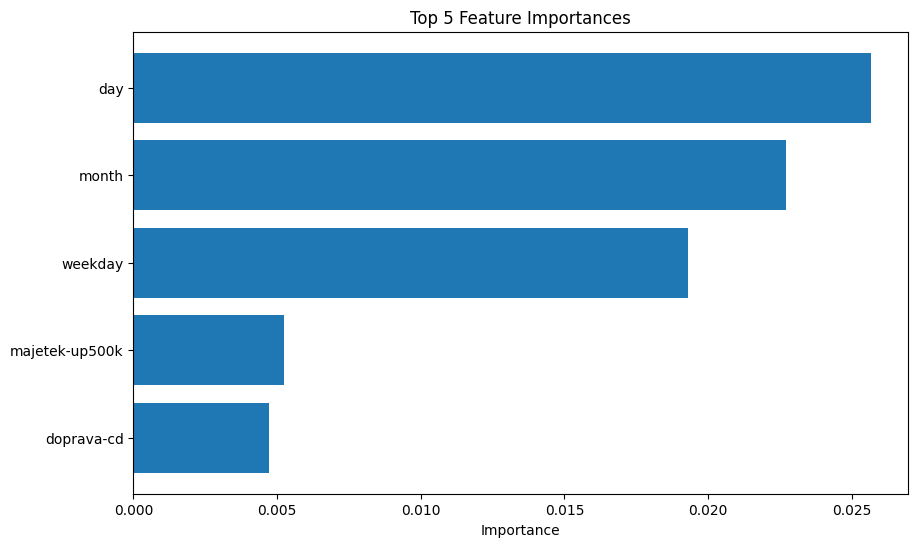

In [17]:
def plot_top_features(model, X_test, top_count=10):
    feature_importances = model.feature_importances_
    feature_names = X_test.columns

    # Sort feature importances and names
    sorted_idx = feature_importances.argsort()[::-1]
    feature_importances_sorted = feature_importances[sorted_idx]
    feature_names_sorted = feature_names[sorted_idx]

    # Select top features
    top_idx = sorted_idx[:top_count]
    feature_importances_top = feature_importances[top_idx]
    feature_names_top = feature_names[top_idx]

    plt.figure(figsize=(10, 6))
    plt.barh(feature_names_top, feature_importances_top)
    plt.title(f'Top {top_count} Feature Importances')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()  # To display the most important features at the top
    plt.show()

    # Create a dataframe with feature names and their importances
    top_features_df = pd.DataFrame({
        'Feature': feature_names_top,
        'Importance': feature_importances_top
    })

    return top_features_df

# Example usage
top_features_rf = plot_top_features(best_rf, X_test, top_count=5)

In [18]:
X_train_top_features = X_train[top_features_rf['Feature'].tolist()]
X_test_top_features = X_test[top_features_rf['Feature'].tolist()]

rf = RandomForestClassifier(
    n_estimators=700,
    random_state=42,
    max_depth=14,
    criterion='entropy',
    class_weight='balanced'
)
rf.fit(X_train_top_features, y_train)

y_pred = rf.predict(X_test_top_features)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X[top_features_rf['Feature'].tolist()])

In [ ]:
print("X shape:",  X[top_features_rf['Feature'].tolist()].shape)
print("shap_values[1] shape:", shap_values.shape)
top_3_features = top_features_rf['Feature'].tolist()


In [35]:
top_features_rf

,Feature,Importance
0,day,0.023283
1,month,0.020068
2,weekday,0.017791
3,majetek-up500k,0.008685
4,spending_type-spender,0.008079
5,doprava-cd,0.005562
6,clothes-newyorker,0.005544
7,new_job-searching,0.005507
8,klientstvi-cez,0.005259
9,clothes-hm,0.005131


In [36]:
print("X shape:",  X[top_features_rf['Feature'].tolist()].shape)
print("shap_values[1] shape:", shap_values.shape)

X shape: (22889, 20)
shap_values[1] shape: (22889, 20, 2)


In [25]:
df_credits, df_atlas, df_payments = read_data()

In [27]:
df_atlas

,user_id,all_intro-2022,atlas_vzorek-2023,atlas_vzorek-2024,all_intro-trendaro_panel_all,sex-woman,sex-man,age-15_17,age-18_24,age-25_34,...,check-tv,check-radio,check-household,check-overdraft,check-naramek,isic2_age-21_26,isic2_age-15_20,isic_age-15_17,isic_age-18_22,isic_age-23_26
0,STUD29866,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
1,STUD35256,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,STUD29684,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,STUD11967,0,0,0,1,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
4,STUD57644,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43528,STUD33520,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43529,STUD64071,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43530,STUD82916,1,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43531,STUD63130,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
top_features_rf

,Feature,Importance
0,day,0.025679
1,month,0.022700
2,weekday,0.019285
3,majetek-up500k,0.005229
4,doprava-cd,0.004729


In [29]:
df_credits.merge(df_atlas, left_on='user', right_on='user_id')

,user,credits,is_active,is_verified,is_locked,wage,user_id,all_intro-2022,atlas_vzorek-2023,atlas_vzorek-2024,...,check-tv,check-radio,check-household,check-overdraft,check-naramek,isic2_age-21_26,isic2_age-15_20,isic_age-15_17,isic_age-18_22,isic_age-23_26
0,STUD29866,141,1,1,0,Peníze,STUD29866,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,STUD35256,0,1,1,0,NaN,STUD35256,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,STUD29684,121,1,1,0,Peníze,STUD29684,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,STUD11967,81,1,1,0,Peníze,STUD11967,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,STUD57644,141,1,1,0,Peníze,STUD57644,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43520,STUD12161,1141,1,1,0,Trendaro,STUD12161,1,1,0,...,0,0,0,0,0,0,0,0,0,0
43521,STUD26121,1693,1,1,0,Trendaro,STUD26121,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43522,STUD54678,789,1,1,0,Peníze,STUD54678,1,0,0,...,0,0,0,0,0,0,0,0,0,0
43523,STUD72037,16,1,1,0,Lékaři bez hranic,STUD72037,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_